# Result

Random Search            best Score: 0.6941 with 100 iterations
Bayesian Optimization GP best Score: 0.6963 with 100 iterations
Bayesian Optimization RF best Score: 0.6891 with 100 iterations


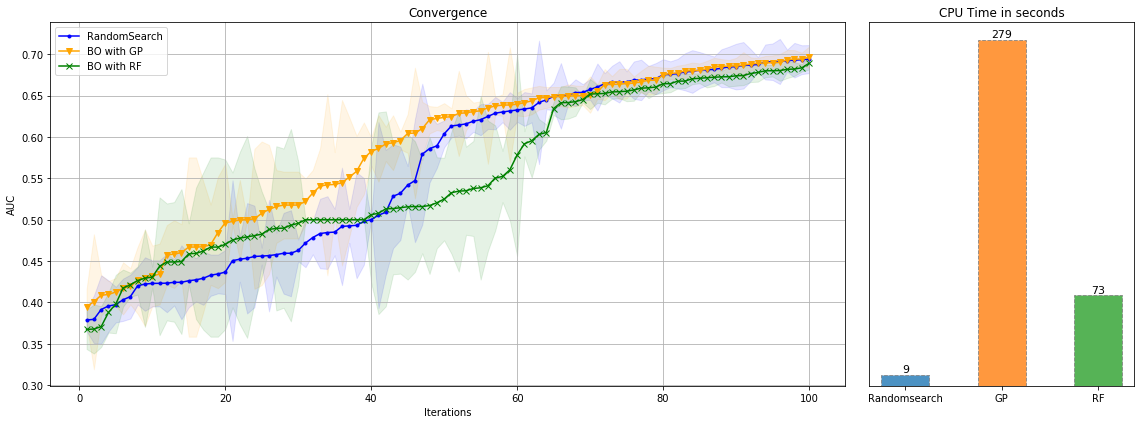

In [8]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from util import dump_result,load_result

RM_results_50 =load_result("jm1_randomsearch2models_5f_50.json")
BO_results_50 = load_result("jm1_parallel2models_np_5f_50_eips.json")
rm_50_score_summary= load_result("jm1_rm_50_score_summary2models_5f_50.json")
rm=rm_50_score_summary.sort_values(by="mean_score" , ascending=True) 

plt.rcParams["figure.figsize"] = (16, 6)
fig = plt.figure()
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])

bo_gp = pd.DataFrame()
bo_gp['mean_test_score']= BO_results_50["GP"]['CV']['mean_test_score']
bo_gp['std_test_score']=BO_results_50["GP"]['CV']['std_test_score']
bo_gp = bo_gp.sort_values(by="mean_test_score" , ascending=True)

bo_rf = pd.DataFrame()
bo_rf['mean_test_score']= BO_results_50["RF"]['CV']['mean_test_score']
bo_rf['std_test_score']=BO_results_50["RF"]['CV']['std_test_score']
bo_rf = bo_rf.sort_values(by="mean_test_score" , ascending=True)

ax0 = plt.subplot(gs[0])
ax0.plot(range(1,len(rm)+1),rm["mean_score"],label="RandomSearch",color ='b',marker=".", markersize=6)
r1 = list(map(lambda x: x[0]-x[1], zip(rm["mean_score"], rm["std_score"])))
r2 = list(map(lambda x: x[0]+x[1], zip(rm["mean_score"], rm["std_score"])))
ax0.fill_between(range(1,len(rm)+1), r1, r2, color ='b',alpha=0.1)


ax0.plot(range(1,len(BO_results_50["GP"]['all_cv_results'])+1),bo_gp['mean_test_score'],label="BO with GP", color ='orange',marker="v", markersize=6)
r_gp1 = list(map(lambda x: x[0]-x[1], zip(bo_gp["mean_test_score"],bo_gp["std_test_score"])))
r_gp2 = list(map(lambda x: x[0]+x[1], zip(bo_gp["mean_test_score"],bo_gp["std_test_score"])))
ax0.fill_between(range(1,len(BO_results_50["GP"]['all_cv_results'])+1), r_gp1, r_gp2, color ='orange',alpha=0.1)

ax0.plot(range(1,len(BO_results_50["RF"]['all_cv_results'])+1),bo_rf['mean_test_score'],label="BO with RF",color ='g',marker="x", markersize=6)
r_rf1 = list(map(lambda x: x[0]-x[1], zip(bo_rf["mean_test_score"],bo_rf["std_test_score"])))
r_rf2 = list(map(lambda x: x[0]+x[1], zip(bo_rf["mean_test_score"],bo_rf["std_test_score"])))
ax0.fill_between(range(1,len(BO_results_50["RF"]['all_cv_results'])+1), r_rf1, r_rf2, color ='g',alpha=0.1)
    
ax0.set_xlabel('Iterations')
ax0.set_ylabel('AUC')
ax0.set_title('Convergence')
ax0.legend()
ax0.grid()

ax1 = plt.subplot(gs[1])
rm_time = RM_results_50["LGBMClassifier"]["CPU_Time"]+RM_results_50["SVC"]["CPU_Time"]
ax1.bar("Randomsearch", rm_time, label="Randomsearch", width=0.5, alpha=0.8, ec='grey', ls="--")
ax1.axes.get_yaxis().set_visible(False)
ax1.text("Randomsearch", rm_time + 0.05, '%.0f' % rm_time, ha='center', va='bottom', fontsize=11)
print( "Random Search           "+' best Score:', round(RM_results_50["LGBMClassifier"]['best_score'], 4), 'with', len(rm), 'iterations')
for i  in BO_results_50.keys():
    time = BO_results_50[i]['CPU_Time']
    ax1.bar(i, time, label=i, width=0.5, alpha=0.8, ec='grey', ls="--")
    ax1.axes.get_yaxis().set_visible(False)
    ax1.set_title('CPU Time in seconds')
    ax1.text(i, time + 0.05, '%.0f' % time, ha='center', va='bottom', fontsize=11)
    print( "Bayesian Optimization "+i+' best Score:', round(BO_results_50[i]['best_score'], 4), 'with', len(BO_results_50[i]['all_cv_results']), 'iterations')
plt.tight_layout()

# Preparing data

In [1]:
import numpy as np
import base64
import os
from os.path import join
import sys

def mprint(msg):
    from datetime import datetime
    """info"""
    cur_time = datetime.now().strftime('%m-%d %H:%M:%S')
    print(f"INFO  [{cur_time}] {msg}")

def Config_DIRS():

    if len(sys.argv) == 1:
        # default local
        ROOT_DIR = os.getcwd()
        DIRS = {
            'input': join(ROOT_DIR, 'data'),
            'output': join(ROOT_DIR, 'predictions'),
            'program': join(ROOT_DIR, 'ingestion_program'),
            'submission': join(ROOT_DIR, 'automl')
        }
    elif len(sys.argv) == 3:
        # default local
        ROOT_DIR = os.getcwd()
        DIRS = {
            'input': join(ROOT_DIR, 'data'),
            'output': join(ROOT_DIR, 'predictions'),
            'program': join(ROOT_DIR, 'ingestion_program'),
            'submission': join(ROOT_DIR, 'automl')
        }

    elif len(sys.argv) == 5:
        # run in codalab
        DIRS = {
            'input': sys.argv[1],
            'output': sys.argv[2],
            'program': sys.argv[3],
            'submission': sys.argv[4]
        }
    elif len(sys.argv) == 6 and sys.argv[1] == 'local':
        # full call in local
        DIRS = {
            'input': sys.argv[2],
            'output': sys.argv[3],
            'program': sys.argv[4],
            'submission': sys.argv[5]
        }
    else:
        raise ValueError("Wrong number of arguments")
    sys.path.append(DIRS['submission'])
    print(DIRS)
    return(DIRS)

DIRS = Config_DIRS()

import reader

info = {
	"table_sep" : ',',
	"target_name" : 'defects',
	"miss_values":'?'
}


datanames = [f for f in os.listdir(DIRS['input']) if not f.startswith('.')]
reader = reader.Reader(sep = info['table_sep'],
						miss_values=info['miss_values']
						)

for dataname in datanames:
        mprint(f'Read data: {dataname}')
        datapath = join(DIRS['input'], dataname)

data = reader.read_split([datapath], target_name=info['target_name'])
print(data.keys())



{'input': 'D:\\caicai\\result_output\\MasterThesis_Automl-master\\MasterThesis_Automl\\data', 'output': 'D:\\caicai\\result_output\\MasterThesis_Automl-master\\MasterThesis_Automl\\predictions', 'program': 'D:\\caicai\\result_output\\MasterThesis_Automl-master\\MasterThesis_Automl\\ingestion_program', 'submission': 'D:\\caicai\\result_output\\MasterThesis_Automl-master\\MasterThesis_Automl\\automl'}
INFO  [08-08 18:15:04] Read data: jm1.csv

Start [read_split]:
----Start [pre_clean]:

reading csv : D:\caicai\result_output\MasterThesis_Automl-master\MasterThesis_Automl\data\jm1.csv ...
cleaning data ...
----End   [pre_clean]. Time elapsed: 4.22 sec.

> Number of common features : 21

gathering and crunching for train and test datasets ...
reindexing for train and test datasets ...
dropping training duplicates ...
dropping constant variables on training set ...

> % missing values on train set:
uniq_Opnd      0.0
uniq_Op        0.0
total_Opnd     0.0
total_Op       0.0
branchCount    0.0

D:\caicai\result_output\MasterThesis_Automl-master\MasterThesis_Automl\automl\reader.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_train[path] = train[~is_null].drop(target_name, axis=1)
C:\Users\Cheng Fang\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Cheng Fang\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


# Random Search

In [3]:
import pandas as pd
import lightgbm as lgb
from sklearn.svm import SVC
from util import dump_result,load_result
from skopt.space import Real, Categorical, Integer
from randomsearchcv import RandomOptimiser

df_train = data['train'] #df_test = data['test']
y = data['target'] #y_test = data['y_test']

models = {
    'LGBMClassifier': lgb.LGBMClassifier(objective='binary', seed=0),
    'SVC':SVC(max_iter=1000,random_state=0)
}

params = {
    'LGBMClassifier': {'is_unbalance':[True, False],
                     'learning_rate':[0.01,0.1,0.5,1] ,
                     'boosting_type': ['gbdt', 'dart'],
                     'n_estimators': [10,50,100,200,350, 500],
                     'max_bin': [100,400,1000,5000,8000, 10000],
                     'feature_fraction': [0.01,0.1,0.5,1],
                     'reg_alpha': Real(low=1e-09, high=1000, prior='log-uniform', name="reg_alpha"),
                     'reg_lambda': Real(low=1e-09, high=1000, prior='log-uniform', name="reg_alpha")},
    'SVC': {
            "class_weight": ['balanced',None],
            'C': Real(1e-6, 1e+6, 'log-uniform', name="C"),  
            'gamma': Real(1e-6, 1e+1, 'log-uniform', name="C"),
            'degree': [1,2,3,4,5,6,7,8], 
            'kernel': ['linear', 'poly', 'rbf']}
}

RO = RandomOptimiser(models, params,perform_scaling=True)
random_result=RO.fit(df_train, y,n_iter=50 )

Running RandomSearchCV for LGBMClassifier.
took CPU Time: 4.0s,clock time73.0s, candidates checked:50 ,best CV score: 0.69410901 ± 0.0169

Running RandomSearchCV for SVC.
took CPU Time: 5.0s,clock time25.0s, candidates checked:50 ,best CV score: 0.64968887 ± 0.0397



In [4]:
rm_50_score_summary=RO.score_summary(sort_by='mean_score')

LGBMClassifier
SVC


In [5]:
dump_result(random_result,"randomsearch2models_5f_50",save_with_time=False)
dump_result(rm_50_score_summary,"rm_50_score_summary2models_5f_50",save_with_time=False)

Dump successful! File Name: jm1_randomsearch2models_5f_50.json
Dump successful! File Name: jm1_rm_50_score_summary2models_5f_50.json


# Bayesian Optimization

In [6]:
from sklearn.model_selection import train_test_split
from skopt.space import Real, Categorical, Integer
from optimisation_fs import Optimiser
from model import Classifier
import pandas as pd
from util import dump_result,load_result

df_train = data['train'] #df_test = data['test']
y = data['target'] #y_test = data['y_test']


optimiser = Optimiser(verbose=0,n_folds=5,parallel_strategy=True)
search_space_LGB = Classifier(strategy = "LightGBM").get_search_spaces(need_feature_selection=False)
search_space_SVC = Classifier(strategy = "SVC").get_search_spaces(need_feature_selection=False)

best_param,results = optimiser.optimise_step( space = [(search_space_LGB,50),(search_space_SVC,50)],
                                              df_train=df_train,
                                              df_target=y,
                                              set_callbacks=True,
                                              npoints=6)
    
    
dump_result(results,"parallel2models_np_5f_50_eips",save_with_time=False)



Start [optimise_step]:
INFO  [08-08 18:19:22] Start turning Hyperparameters .... 

>>> Categorical Features have encoded with :{'strategy': 'label_encoding'}

INFO  [08-08 18:19:22] start tuning  with Surrogate Model:GP...

took CPU Time: 279.0s,clock time: 225.0s, candidates checked:100 ,best CV score: 0.69630667 ± 0.0129

INFO  [08-08 18:23:07] start tuning  with Surrogate Model:RF...

took CPU Time: 73.0s,clock time: 104.0s, candidates checked:100 ,best CV score: 0.6890559 ± 0.0074


######## Congratulations! Here is the Best Parameters: #######
Best Score is: 0.6963066728484417
with Surrogate Model GP
{'model': LGBMClassifier(boosting_type='dart', class_weight=None, colsample_bytree=1.0,
        feature_fraction=1.0, importance_type='split', is_unbalance=False,
        learning_rate=1.0, max_bin=100, max_depth=-1, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=500,
        n_jobs=-1, nthread=-1, num_leaves=31, objective='binary',
        ran

In [32]:
#RM_results =load_result("jm1_Random_5f_50_20190803083147.json")
#BO_results = load_result("jm1_Random_5f_50_20190803083147.json")


In [10]:
from sklearn.model_selection import train_test_split
from skopt.space import Real, Categorical, Integer
from optimization_combi import automl_Optimiser
from model import Classifier
import pandas as pd
from util import dump_result,load_result

df_train = data['train'] #df_test = data['test']
#df_train = pd.DataFrame(df_train)
y = data['target'] #y_test = data['y_test']


optimiser = automl_Optimiser(verbose=0,n_folds=5,parallel_strategy=True,perform_scaling=True)
search_space_LGB = Classifier(strategy = "LightGBM").get_search_spaces(need_feature_selection=False)
search_space_SVC = Classifier(strategy = "SVC").get_search_spaces(need_feature_selection=False)

best_param,results = optimiser.optimise_step( space = [(search_space_LGB,50),(search_space_SVC,50)],
                                              df_train=df_train,
                                              df_target=y,
                                              set_callbacks=True,
                                              npoints=6,
                                            nrandom=2)
    
    
#dump_result(results,"parallel2models_np_nrm_5f_50_eips",save_with_time=False)



Start [optimise_step]:
INFO  [08-08 18:26:43] Start turning Hyperparameters .... 

>>> Categorical Features have encoded with :{'strategy': 'label_encoding'}

>>> Numerical Features have encoded with :Scaler

INFO  [08-08 18:26:43] start tuning  with Surrogate Model:GP...

took CPU Time: 25.0s,clock time: 23.0s, candidates checked:24 ,best CV score: 0.69338953 ± 0.0117

INFO  [08-08 18:27:06] start tuning  with Surrogate Model:RF...

took CPU Time: 15.0s,clock time: 39.0s, candidates checked:24 ,best CV score: 0.67423497 ± 0.0116


######## Congratulations! Here is the Best Parameters: #######
Best Score is: 0.6933895330080385
with Surrogate Model GP
{'model': LGBMClassifier(boosting_type='dart', class_weight=None, colsample_bytree=1.0,
        feature_fraction=0.3934491325295981, importance_type='split',
        is_unbalance=True, learning_rate=0.6285803549901531, max_bin=7850,
        max_depth=-1, min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimator

In [11]:
dump_result(results,"parallel2models_np_nrm_5f_50_eips",save_with_time=False)

Dump successful! File Name: jm1_parallel2models_np_nrm_5f_50_eips.json


In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from util import dump_result,load_result

RM_results_50 =load_result("jm1_randomsearch2models_5f_50.json")
BO_results_50 = load_result("jm1_parallel2models_np_5f_50_eips.json")
BO_rm_results_50 = load_result("jm1_parallel2models_np_nrm_5f_50_eips.json")
rm_50_score_summary= load_result("jm1_rm_50_score_summary2models_5f_50.json")
rm=rm_50_score_summary.sort_values(by="mean_score" , ascending=True) 

plt.rcParams["figure.figsize"] = (20, 6)
fig = plt.figure()
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])

bo_gp = pd.DataFrame()
bo_gp['mean_test_score']= BO_results_50["GP"]['CV']['mean_test_score']
bo_gp['std_test_score']=BO_results_50["GP"]['CV']['std_test_score']
bo_gp = bo_gp.sort_values(by="mean_test_score" , ascending=True)

bo_rf = pd.DataFrame()
bo_rf['mean_test_score']= BO_results_50["RF"]['CV']['mean_test_score']
bo_rf['std_test_score']=BO_results_50["RF"]['CV']['std_test_score']
bo_rf = bo_rf.sort_values(by="mean_test_score" , ascending=True)

bo_rm_gp = pd.DataFrame()
bo_rm_gp['mean_test_score']= BO_rm_results_50["GP"]['CV']['mean_test_score']
bo_rm_gp['std_test_score']=BO_rm_results_50["GP"]['CV']['std_test_score']
bo_rm_gp = bo_rm_gp.sort_values(by="mean_test_score" , ascending=True)

bo_rm_rf = pd.DataFrame()
bo_rm_rf['mean_test_score']= BO_rm_results_50["RF"]['CV']['mean_test_score']
bo_rm_rf['std_test_score']=BO_rm_results_50["RF"]['CV']['std_test_score']
bo_rm_rf = bo_rm_rf.sort_values(by="mean_test_score" , ascending=True)

ax0 = plt.subplot(gs[0])
ax0.plot(range(1,len(rm)+1),rm["mean_score"],label="RandomSearch",color ='b',marker=".", markersize=6)
r1 = list(map(lambda x: x[0]-x[1], zip(rm["mean_score"], rm["std_score"])))
r2 = list(map(lambda x: x[0]+x[1], zip(rm["mean_score"], rm["std_score"])))
ax0.fill_between(range(1,len(rm)+1), r1, r2, color ='b',alpha=0.1)


ax0.plot(range(1,len(BO_results_50["GP"]['all_cv_results'])+1),bo_gp['mean_test_score'],label="BO with GP", color ='orange',marker="v", markersize=6)
r_gp1 = list(map(lambda x: x[0]-x[1], zip(bo_gp["mean_test_score"],bo_gp["std_test_score"])))
r_gp2 = list(map(lambda x: x[0]+x[1], zip(bo_gp["mean_test_score"],bo_gp["std_test_score"])))
ax0.fill_between(range(1,len(BO_results_50["GP"]['all_cv_results'])+1), r_gp1, r_gp2, color ='orange',alpha=0.1)

ax0.plot(range(1,len(BO_results_50["RF"]['all_cv_results'])+1),bo_rf['mean_test_score'],label="BO with RF",color ='g',marker="x", markersize=6)
r_rf1 = list(map(lambda x: x[0]-x[1], zip(bo_rf["mean_test_score"],bo_rf["std_test_score"])))
r_rf2 = list(map(lambda x: x[0]+x[1], zip(bo_rf["mean_test_score"],bo_rf["std_test_score"])))
ax0.fill_between(range(1,len(BO_results_50["RF"]['all_cv_results'])+1), r_rf1, r_rf2, color ='g',alpha=0.1)


ax0.plot(range(1,len(BO_rm_results_50["GP"]['all_cv_results'])+1),bo_rm_gp['mean_test_score'],label="BO+random with GP", color ='r',marker="v", markersize=6)
r_gp1 = list(map(lambda x: x[0]-x[1], zip(bo_rm_gp["mean_test_score"],bo_rm_gp["std_test_score"])))
r_gp2 = list(map(lambda x: x[0]+x[1], zip(bo_rm_gp["mean_test_score"],bo_rm_gp["std_test_score"])))
ax0.fill_between(range(1,len(BO_rm_results_50["GP"]['all_cv_results'])+1), r_gp1, r_gp2, color ='r',alpha=0.1)

ax0.plot(range(1,len(BO_rm_results_50["RF"]['all_cv_results'])+1),bo_rm_rf['mean_test_score'],label="BO+random with RF",color ='y',marker="x", markersize=6)
r_rf1 = list(map(lambda x: x[0]-x[1], zip(bo_rm_rf["mean_test_score"],bo_rm_rf["std_test_score"])))
r_rf2 = list(map(lambda x: x[0]+x[1], zip(bo_rm_rf["mean_test_score"],bo_rm_rf["std_test_score"])))
ax0.fill_between(range(1,len(BO_rm_results_50["RF"]['all_cv_results'])+1), r_rf1, r_rf2, color ='y',alpha=0.1)
ax0.set_ylim((0.6, 0.7))

ax0.set_xlabel('Iterations')
ax0.set_ylabel('AUC')
ax0.set_title('Convergence')
ax0.legend()
ax0.grid()

ax1 = plt.subplot(gs[1])
rm_time = RM_results_50["LGBMClassifier"]["CPU_Time"]+RM_results_50["SVC"]["CPU_Time"]
ax1.bar("Randomsearch", rm_time, label="Randomsearch", width=0.5, alpha=0.8, ec='grey', ls="--")
ax1.axes.get_yaxis().set_visible(False)
ax1.text("Randomsearch", rm_time + 0.05, '%.0f' % rm_time, ha='center', va='bottom', fontsize=11)
print( "Random Search"+' best Score:', round(RM_results_50["LGBMClassifier"]['best_score'], 4), 'with', len(rm), 'iterations')
for i  in BO_results_50.keys():
    time = BO_results_50[i]['CPU_Time']
    ax1.bar(i, time, label=i, width=0.5, alpha=0.8, ec='grey', ls="--")
    ax1.axes.get_yaxis().set_visible(False)
    ax1.set_title('CPU Time in seconds')
    ax1.text(i, time + 0.05, '%.0f' % time, ha='center', va='bottom', fontsize=11)
    print( "BO         "+i+' best Score:', round(BO_results_50[i]['best_score'], 4), 'with', len(BO_results_50[i]['all_cv_results']), 'iterations')
for i  in BO_rm_results_50.keys():
    time = BO_rm_results_50[i]['CPU_Time']
    ax1.bar(i+"+random", time, label=i, width=0.5, alpha=0.8, ec='grey', ls="--")
    ax1.axes.get_yaxis().set_visible(False)
    ax1.set_title('CPU Time in seconds')
    ax1.text(i+"+random", time + 0.05, '%.0f' % time, ha='center', va='bottom', fontsize=11)
    print( "BO+Random  "+i+' best Score:', round(BO_rm_results_50[i]['best_score'], 4), 'with', len(BO_rm_results_50[i]['all_cv_results']), 'iterations')
plt.tight_layout()

ModuleNotFoundError: No module named 'util'